# Combined analysis of J1206
This notebook takes the MCMC chains of multiple runs with various configurations and choices of the model and combines the output of the lens modelling with the kinematics data, time-delay data and trunslates them together into constrainst on the angular diameter distances.

In [1]:
import pickle
import copy
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

rc('xtick', labelsize=12) 
rc('ytick', labelsize=12)

%matplotlib inline

import lenstronomy.Util.util as util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Workflow.fitting import Fitting
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Analysis.lens_properties import LensProp
from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

import lenstronomy.Plots.output_plots as out_plot
import lenstronomy.Util.class_creator as class_creator

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)

## data sets and priors

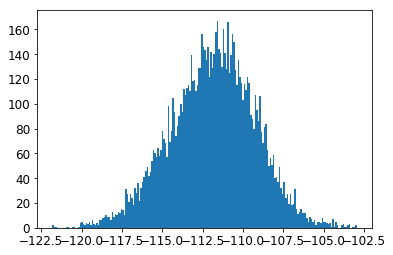

In [2]:
# =======================================
# LENS MODEL POSTERIORS FROM IMAGING DATA
# =======================================

# read in list of MCMC samples from the modelling of the imaging data (see appropriate notebook)
# this are the job names executed and this notebook can handle an arbitrary list of job names corresponding to different model outputs
# the model outputs should be stored in the conventions of the modelling notebooks and will be loaded in this notebook with pickle.
# Attention: pickle is not platform (and python version) independent and should be avoided for public available data.=
# Parameter conventions may varry from different lenstronomy versions. Be adviced to run your own chains to analyse them with this notebook.
job_name_loaded_list = ['test']
num_models = len(job_name_loaded_list)

# ============================================
# VELOCITY DISPERSION MEASUREMENT AND ANALYSIS
# ============================================

# velocity disperions measurement in km/s
vel_disp = 290  # from Agnello et al.
sigma_vel_disp = 30  # from Agnello et al.
R_slit = 1.0 # 3.8  # slit lenght in arc sec (we only use part of the slit length in this analysis)
dR_slit = 1.  # slit width in arc sec
psf_fwhm = 1.0  # sseing conditions of the observations

kwargs_aperture = {'length': R_slit, 'width': dR_slit, 'center_ra': 0, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OsipkovMerritt'  # anisotropy model applied
aperture_type = 'slit'  # type of aperture used
# numerical options to perform the numerical integrals
kwargs_galkin_numerics = {'sampling_number': 1000, 'interpol_grid_num': 100, 'log_integration': True,
                           'max_integrate': 100, 'min_integrate': 0.001}
MGE_light = True  # we use a multi-Gaussian expansion to perform the luminous light de-projection
MGE_mass = True # we use a multi-Gaussian expansion to perform the mass distribution de-projection



# anisotropy priors
aniso_param_min = 0.5
aniso_param_max = 5
def draw_anisotropy():
    # draw of the anisotropy prior distribution
    return np.random.uniform(aniso_param_min, aniso_param_max)

def draw_vel_disp():
    # sampling of the measured velocity dispersion distribution
    return vel_disp + np.random.randn(1)[0]*sigma_vel_disp


# ====================================
# LENS REDSHIFTS AND DEFAULT COSMOLOGY
# ====================================

# redshifts
z_d = 0.745
z_s = 1.789
# instance of the LCDM cosmology class
from lenstronomy.Cosmo.lens_cosmo import LCDM
cosmoProp = LCDM(z_lens=z_d, z_source=z_s)


# ===========================
# TIME DELAY AND MICROLENSING
# ===========================

# time delay
time_delay_path = os.path.join(base_path, 'Data', 'TimeDelay', "time_delay.npy")
[days, probas] = np.load(time_delay_path)
# we compute the CDF of the time-delay distribution
from lenstronomy.Util.prob_density import Approx
dt_draw = Approx(days, probas)

def draw_dt_measured(n=1):
    # sampling from the time-delay measured posteriors
    return dt_draw.draw(n=n)
# here a quick test of the distribution
dt_sample = draw_dt_measured(n=10000)
plt.hist(dt_sample, bins=200)
plt.show()


# micro-lensing time-delays
# see Birrer et al. 2018 for details on the assumption that went into this computation
# micro-lensing specs:
# M_bh, kappa, gamma, accretion size

#Image A
micro_file_A = os.path.join(base_path, 'Data', 'TimeDelay', 'MicroLensing', 'ImgA', 'TDmap_1.0R0_incl0.0_pa0.0.fits')
micro_lensing_A = fits.open(micro_file_A)
micro_lensing_A = micro_lensing_A[0].data
A_micro_pdf = micro_lensing_A.flatten()

#Image B
micro_file_B = os.path.join(base_path, 'Data', 'TimeDelay', 'MicroLensing', 'ImgB', 'TDmap_1.0R0_incl0.0_pa0.0.fits')
micro_lensing_B = fits.open(micro_file_B)
micro_lensing_B = micro_lensing_B[0].data
B_micro_pdf = micro_lensing_B.flatten()


def draw_micro_lensing(num=1):
    """
    return a realisation of the micro-lensing delay for image A and B
    """
    nA = len(A_micro_pdf)
    iA_random = np.random.uniform(low=0, high=nA, size=num)
    dt_A = A_micro_pdf[iA_random.astype(int)]
    
    nB = len(B_micro_pdf)
    iB_random = np.random.uniform(low=0, high=nB, size=num)
    dt_B = B_micro_pdf[iB_random.astype(int)]
    return dt_A, dt_B

def draw_dt():
    """
    joint draw of the measured time delay PDF and microlensingn PDFs of the two images
    """
    dt_A_micro, dt_B_micro = draw_micro_lensing()
    return draw_dt_measured() + dt_A_micro - dt_B_micro

def BIC_compute(num_data, num_model, max_logL):
    """
    Bayesian information criterion
    """
    return np.log(num_data)*num_model - 2 * max_logL

## read in lens model output
Re-computes one parameter position in each sample

In [4]:
num_samples_read = 1000  # depending on the number of different chains/models, we do not need all of the
# posteriors to post-process for computational reasons. As long as the sample is representative of the full
# posteriors, everyting should be fine.

# evaluate goodness of fit with shared mask.
mask_shared_bool = True

# a list of attributs that are collected for all the different samples.
kwargs_list = []
source_result_list = []
lens_light_result_list = []
r_eff_list = []
lensProp_list = []
lensAnalysis_list = []

chi2_list = []
BIC_list = []
source_type_list = []
lens_type_list = []
numerics_list = []
mask_list = []
perturber_number_list = []

#sample_folder = 'Samples'
sample_folder = os.path.join(base_path, 'Temp')
#sample_folder = '/Users/sibirrer/mount/external/TDSL/SDSSJ1206'
for i, job_name in enumerate(job_name_loaded_list):
    # read in posterior sampling file
    output_temp = job_name +'_out.txt'
    output_temp = os.path.join(sample_folder, output_temp)
    f = open(output_temp, 'rb')
    [input_, output_] = pickle.load(f)
    f.close()
 
    # get back all the kwargs and files in the same format as beeing pickled
    fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_
    lens_result, source_result, lens_light_result, ps_result, cosmo_result, multi_band_list_out, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc, kwargs_params_out = output_
    # make an instance of the LensProp class with the configuration of the model being read in
    lensProp_list.append(LensProp(z_d, z_s, kwargs_model))
    # make an instance of the LensProp class with the configuration of the model being read in
    lensAnalysis = LensAnalysis(kwargs_model)
    lensAnalysis_list.append(lensAnalysis)
    # read in the parameter configurations as passed to the FittingSequence class
    lens_params = kwargs_params_out['lens_model']
    source_params = kwargs_params_out['source_model']
    lens_light_params = kwargs_params_out['lens_light_model']
    ps_params = kwargs_params_out['point_source_model']
    cosmo_params = kwargs_params_out['cosmography']
    
    # make an instance of the Param() class with the same configuration as being sampled by the MCMC
    kwargs_fixed_lens, kwargs_fixed_source, kwargs_fixed_lens_light, kwargs_fixed_ps, kwargs_fixed_cosmo = lens_params[2], source_params[2], lens_light_params[2], ps_params[2], cosmo_params[2]
    param_class = Param(kwargs_model, kwargs_constraints, kwargs_fixed_lens, kwargs_fixed_source, kwargs_fixed_lens_light, kwargs_fixed_ps, kwargs_fixed_cosmo, kwargs_lens_init=lens_result)
    
    # now we loop through the posterior samples and expand the sampled parameters to recover the full lenstronomy keyword arguments
    # we append those full list of keyword arguments for later use
    kwargs_mcmc_list = []    
    for k in range(num_samples_read):
        j = len(samples_mcmc) - num_samples_read + k - 1
        kwargs_mcmc_list.append(param_class.args2kwargs(samples_mcmc[j,:]))
    kwargs_list.append(kwargs_mcmc_list)
    # we select the zeroth band (well, we only did a single band modelling here)
    band_i = 0
    [kwargs_data, kwargs_psf, kwargs_numerics] = multi_band_list[band_i]
    # we extract the mask. This will be used later to assess the goodness of fit
    mask = kwargs_numerics['mask']
    mask_list.append(np.sum(mask))
        
    # to evaluate the goodness of fit, we make sure to do so by using always the same mask
    if i == 0:
        mask_shared = mask
    if mask_shared_bool is True:
        mask = mask_shared
    kwargs_numerics['mask'] = mask_shared
    # we find the posterior sample index of the maximul likelihood
    i_plot = np.argmax(dist_mcmc)
    lens_result, source_result, lens_light_result, ps_result, cosmo_result = param_class.args2kwargs(samples_mcmc[i_plot,:])
    # we creat an image modelling class based on our options chosen
    imageModel = class_creator.create_image_model(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model)
    # we compute the logL for the given model
    max_logL = imageModel.likelihood_data_given_model(lens_result, source_result, lens_light_result, ps_result, source_marg=False)
    # here we compute the full linear inversion
    model, error_map, cov_param, param = imageModel.image_linear_solve(lens_result, source_result, lens_light_result, ps_result, inv_bool=True)
    # we compute some goodness of fit quantities
    chi2_list.append(imageModel.reduced_chi2(model, error_map=error_map))    
    num_data = np.sum(mask)
    num, param_list = param_class.num_param()
    num_model = num + param_class.num_param_linear()
    BIC = BIC_compute(num_data, num_model, max_logL)
    BIC_list.append(BIC)
    print(BIC, num_model, max_logL,  num_data, 'BIC', 'num_model', 'logL', 'num_data')
    
    # we want to keep track of the source type, here specified by n_max of the shapelet order
    n_max = -1
    for kwargs in source_result:
        if 'n_max' in kwargs:
            n_max = kwargs['n_max']
    source_type_list.append(n_max)
    
    # we want to keep track of the number of perturbers modelled for a specific model
    lens_model_temp = kwargs_model['lens_model_list']
    num_pert = 0
    for model in lens_model_temp:
        if model in ['SIS', 'NFW']:
            num_pert += 1
    perturber_number_list.append(num_pert)
    lens_type_list.append(kwargs_model['lens_model_list'])
    numerics_list.append(kwargs_numerics.get('subgrid_res', 1))
    # here we keep track of the parameters of the source and lens light of the best fit model, this includes the linear amplitude parameters that were not tracked in the original MCMC output
    # this is important when using the light models to infere the kinematics or other light quantity related properties.
    source_result_list.append(source_result)
    lens_light_result_list.append(lens_light_result)
    # here we compute the projected half-light radius of the model. We specify the center and only include light models that describe part of the main deflector
    r_eff = lensAnalysis.half_light_radius_lens(lens_light_result,
                                                    center_x=lens_light_result[0]['center_x'],
                                                    center_y=lens_light_result[0]['center_x'],
                                                    model_bool_list=kwargs_model['light_model_deflector_bool'], deltaPix=0.01, numPix=500)
    print(r_eff, 'r_eff')
    r_eff_list.append(r_eff) 
    print(job_name)
    print('=====')


7589.441109423646 47 -3598.1327232613885 4296.0 BIC num_model logL num_data
0.34578935813584555 r_eff
test
=====


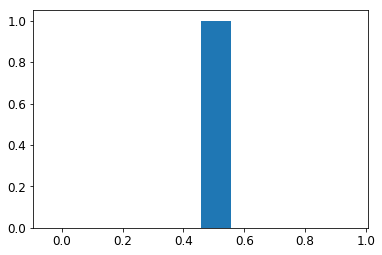

In [5]:
# computing the half-light radius of the reconstructed source
# this is simply a statistics that ensures that the properties of the source galaxy is not fastly deviating.
R_h_list = []
for i, source_result in enumerate(source_result_list):
    deltaPix_source_norm = 0.01
    R_h = lensAnalysis_list[i].half_light_radius_source(source_result_list[i], deltaPix=0.01, numPix=100)
    R_h_list.append(R_h)
plt.hist(R_h_list)
plt.show()



In [9]:
"""
Now we compute derived quantities from the lens model, such as log power-law slope at the Einstein radius etc.
This computation is mainly to compare different lens models and for presenting modelling results 
"""

mcmc_file_name = '_derived_lens_model.txt'
new_compute = False   # if filenmae is already there, read out existing file.

# here are the parameters being saved in a new file
labels_compressed = [r"$\theta_E$", r"$\gamma'$", r"$\gamma_{ext}$", r"$\phi_{ext}$", r"$\gamma_{ext foreground}$", r"$\phi_{ext foreground}$",r"$\Delta\phi_{fermat}$",  r"$\theta_{pert}$", r"$\kappa_{G1+G2}$"]
num_param_compressed = len(labels_compressed)
mcmc_compressed_list = []

# we loop through all the model choices
for k, job_name in enumerate(job_name_loaded_list):
    mcmc_out_temp = job_name + mcmc_file_name
    mcmc_out_temp = os.path.join(base_path, 'Temp', mcmc_out_temp)
    if new_compute is True or not os.path.exists(mcmc_out_temp):
        # we get the instances of the correct lensAnalysis and LensModel classes to perform the computations
        lensAnalysis = lensAnalysis_list[k]
        lensModelExtensions = LensModelExtensions(lensAnalysis.LensModel)
        mcmc_compressed = np.zeros((num_samples_read, num_param_compressed))
        # we loop through all samples selected
        for l in range(num_samples_read):
            # read out the full keyword arguments from the previous block
            kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_cosmo = kwargs_list[k][l]
            # Fermat potential at the quasar image positions
            fermat_pot = lensAnalysis.fermat_potential(kwargs_lens, kwargs_ps)
            delta_fermat = fermat_pot[1] - fermat_pot[0]  # relative Fermat potential (B-A)
            # external shear parameters in angle and shear strength
            phi_ext, gamma_ext = lensModelExtensions.external_shear(kwargs_lens)
            # same for foreground shear
            phi_ext_foreground, gamma_ext_foreground = lensModelExtensions.external_shear(kwargs_lens, foreground=True)
            # Einstein radius, as defined as the spherical averaged region with <kappa> = 1 centered at main profile center
            theta_E = lensModelExtensions.effective_einstein_radius(kwargs_lens)
            # log power-law slope at the Einstein radius
            gamma = lensModelExtensions.profile_slope(kwargs_lens)  # local logarithmic slope at Einstein radius
            gamma = np.mean(gamma)
            num_pert = perturber_number_list[k]
            
            # now we compute the sum of Einstein radii of the galaxy triplet
            theta_E_pert = 0
            num_lens_models = len(kwargs_lens)
            for i in range(3):
                theta_E_pert += kwargs_lens[num_lens_models-num_pert-1+1]['theta_E']  # we used the convention that the perturber models are the last models in the list
            if num_pert == 6:  # if we add other perturber models G3 and G4
                i_G3 = len(kwargs_lens)-3
                i_G4 = len(kwargs_lens)-2
                # we compute the convergence of G3 and G4 induced at the lens center
                kappa_g3_g4 = lensAnalysis.LensModel.kappa(0, 0, kwargs_lens, k=[i_G3, i_G4])
            else:
                kappa_g3_g4 = 0
            # we add the values to the parameter array
            mcmc_compressed[l] = [theta_E, gamma, gamma_ext, phi_ext, gamma_ext_foreground, phi_ext_foreground, delta_fermat, theta_E_pert, kappa_g3_g4]
 
        print(job_name_loaded_list[k])
        f = open(mcmc_out_temp,'wb')
        pickle.dump(mcmc_compressed, f)
        f.close()
    try:
        f = open(mcmc_out_temp, 'rb')
        mcmc_compressed = pickle.load(f)
        f.close()
    except:
        print(mcmc_out_temp)
        raise ValueError(mcmc_out_temp)
    mcmc_compressed_list.append(mcmc_compressed)

test


In [11]:
"""
Now we compute the angular diameter distance posteriors by combining the image model posteriors with predictions
of the velocity dispersion and by simple sampling the measured time delay (incl. microlensing) and the velocity dispersion
"""

# file name for each model that contains this output
mcmc_file_name = '_diameter_distances.txt'
new_compute = False  # if file exists, we do not need to re-copmpute this (optional)

# Each posterior can be re-simple sampled by drawing other values of the PDFs of the data. This requires less computations 
# of the kinematicds (expensive). This is valid as long as the smallest sample is representative of its PDF.
num_resampling = 20

# parameter names in computed chain
labels_new = [ r"$D_d$", r"$D_{\Delta t}$", r"$r_{ani} / r_{eff}$"]

num_param_new = len(labels_new)
i_Dd = 0 # index of Dd parameter
i_DdDs_Dds = 1 # index of DdDs/Dds parameter (almost Ddt without (1+z))
mcmc_new_list = []

for k, job_name in enumerate(job_name_loaded_list):
    mcmc_out_temp = job_name + mcmc_file_name
    mcmc_out_temp = os.path.join(sample_folder, mcmc_out_temp)
    if new_compute is True or not os.path.exists(mcmc_out_temp):
        # get the right analysis classes for the kinematic computation
        lensProp = lensProp_list[k]
        #lensAnalysis = lensAnalysis_list[k]
        #lensModelExtensions = LensModelExtensions(lensAnalysis.LensModel)
        mcmc_new = np.zeros((num_samples_read*num_resampling, num_param_new))
        r_eff = r_eff_list[k]
        
        i = 0
        for l in range(num_samples_read):
            # read model parameters in lenstronomy conventions
            kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps, kwargs_cosmo = kwargs_list[k][l]
            # compute Fermat potential at the positions of the point sources
            fermat_pot = lensAnalysis.fermat_potential(kwargs_lens, kwargs_ps)
            # compute relative Fermat potential between images A and B (attention of sign)
            delta_fermat = fermat_pot[1] - fermat_pot[0]
            # draw an anisotropy radius from the PDF specified
            aniso_param = draw_anisotropy()
            # set the anisotropy radius. r_eff is pre-computed half-light radius of the lens light
            kwargs_anisotropy = {'r_ani': r_eff * aniso_param}
            # compute the velocity disperson in a pre-specified cosmology (see lenstronomy function)
            # We read out the lens light model kwargs that has previously been solved for the linear amplitude parameters.
            # This is necessary to perform an accurate kinematic estimate as we are using a superposition of different light profiles and their relative amplitudes matter.
            vel_disp_temp = lensProp.velocity_dispersion_numerical(kwargs_lens, lens_light_result_list[k], kwargs_anisotropy, kwargs_aperture,
                                                                       psf_fwhm, aperture_type, anisotropy_model, MGE_light=MGE_light, MGE_mass=MGE_mass, r_eff=r_eff,
                                                                       kwargs_numerics=kwargs_galkin_numerics, lens_model_kinematics_bool=lensProp.kwargs_options['lens_model_deflector_bool'],
                                                                       light_model_kinematics_bool=lensProp.kwargs_options['light_model_deflector_bool'])
            # compute the predicted time delays in the SAME cosmology as the kinematic prediction
            time_delay_temp = lensProp.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
            time_delay_temp= time_delay_temp[1] - time_delay_temp[0]
            
            # now we draw values of the time delay and velocity dispersion from the uncertainties given by the data
            # we can do this multiple times to enhance the sampling
            for m in range(num_resampling):
                # the distance ratios that can be measured. Inputs are a realisation of measured time delays and kinematics and their model predictions 
                Ds_Dds, DdDs_Dds = lensProp.angular_distances(sigma_v_measured=draw_vel_disp(), time_delay_measured=draw_dt(), kappa_ext=0, sigma_v_modeled=vel_disp_temp, fermat_pot=delta_fermat)
                # algebra to get D_d
                Dd = DdDs_Dds/Ds_Dds
                mcmc_new[i] = [Dd, DdDs_Dds, aniso_param]
                i += 1
        print(job_name_loaded_list[k])
        f = open(mcmc_out_temp,'wb')
        pickle.dump(mcmc_new, f)
        f.close()
    f = open(mcmc_out_temp, 'rb')
    mcmc_new = pickle.load(f)
    f.close()
    mcmc_new_list.append(mcmc_new)
    
    

    

test


## sub-selection of posteriors
Previously we have computed the cosmographic posteriors of all the models separately.
In the next section, we merge the posteriors in various ways (e.g. sorting by same model options, BIC selection etc).

In [ ]:

chi2_cut = 1.1
chi2_cut_minimal = 2.5  # whenever a model is above this reduced chi2 value, we ignore it. This is just to make sure
# that when something went wrong in the sampling.

select_all = [True] * len(lens_type_list)
select_chi2_list = [False] * len(lens_type_list)

#select_BIC_power_law_list = np.zeros(len(lens_type_list), dtype=bool)
#select_BIC_composite_list = np.zeros(len(lens_type_list), dtype=bool)

select_composite_list = np.zeros(len(lens_type_list), dtype=bool)# [False] * len(lens_type_list)
select_power_law_list = [False] * len(lens_type_list)
select_foreground_list = [False] * len(lens_type_list)
select_noforeground_list = [False] * len(lens_type_list)
select_3_pert_list = [False] * len(lens_type_list)
select_5_pert_list = [False] * len(lens_type_list)
#select_8_pert_list = [False] * len(lens_type_list)
select_source_0_list = [False] * len(lens_type_list)
select_source_2_list = [False] * len(lens_type_list)
select_source_5_list = [False] * len(lens_type_list)
select_source_8_list = [False] * len(lens_type_list)
select_mask_1_list = [False] * len(lens_type_list)
select_mask_2_list = [False] * len(lens_type_list)
select_power_law_5_list = [False] * len(lens_type_list)
select_power_law_8_list = [False] * len(lens_type_list)
select_composite_5_list = [False] * len(lens_type_list)
select_composite_8_list = [False] * len(lens_type_list)



for i, _ in enumerate(lens_type_list):
    if chi2_list[i] < chi2_cut_minimal:
        if lens_type_list[i][0] == 'SPEMD':
            select_power_law_list[i] = True
            if source_type_list[i] == 5:
                select_power_law_5_list[i] = True
            elif source_type_list[i] == 8:
                select_power_law_8_list[i] = True
        else:
            select_composite_list[i] = True
            if source_type_list[i] == 5:
                select_composite_5_list[i] = True
            elif source_type_list[i] == 8:
                select_composite_8_list[i] = True
        if chi2_list[i] < chi2_cut:
            select_chi2_list[i] = True
        if 'FOREGROUND_SHEAR' in lens_type_list[i]:
            select_foreground_list[i] = True
        else:
            select_noforeground_list[i] = True
        if perturber_number_list[i] == 4:
            select_3_pert_list[i] = True
        if perturber_number_list[i] == 6:
            select_5_pert_list[i] = True
        #if perturber_number_list[i] == 9:
        #    select_8_pert_list[i] = True    
        if source_type_list[i] == -1:
            select_source_0_list[i] = True
        if source_type_list[i] == 2:
            select_source_2_list[i] = True
        if source_type_list[i] == 5:
            select_source_5_list[i] = True
        if source_type_list[i] == 8:
            select_source_8_list[i] = True
        if mask_list[i] == 4296:
            select_mask_1_list[i] = True
        else:
            select_mask_2_list[i] = True
            
            
selection_list = [select_all, select_chi2_list, select_composite_list, select_power_law_list, select_foreground_list, select_noforeground_list, select_3_pert_list, select_5_pert_list, select_source_0_list, select_source_2_list, select_source_5_list, select_source_8_list, select_mask_1_list, select_mask_2_list, select_power_law_5_list, select_power_law_8_list, select_composite_5_list, select_composite_8_list]        
selection_name_list = ['all samples', r'$\chi^2$ cut', 'composite', 'power-law', 'foreground shear', 'simple shear','triplet', 'triplet+2', r'double Sersic', r'+ $n_{max} = 2$', r'+ $n_{max} = 5$', r'+ $n_{max} = 8$', '3.0" mask', '3.2" mask', r'PL $n_{max}=5$', r'PL $n_{max}=9$', r'composite $n_{max}=5$', r'composite $n_{max}=8$']   
         
            
delta_BIC_cut = 0
sample_size_cut_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]   
#select_BIC_list_list = [np.zeros(len(lens_type_list), dtype=bool)] * len(sample_size_cut_list)

BIC_list = np.array(BIC_list)
BIC_min_composite = np.min(BIC_list[select_composite_list])
BIC_composite_sorted = np.sort(BIC_list[select_composite_list])
#BIC_composite_cut = np.maximum(BIC_min_composite + delta_BIC_cut, BIC_composite_sorted[sample_size_cut])

BIC_min_power_law = np.min(BIC_list[select_power_law_list])
BIC_power_law_sorted = np.sort(BIC_list[select_power_law_list])
#BIC_power_law_cut = np.maximum(BIC_min_power_law + delta_BIC_cut, BIC_power_law_sorted[sample_size_cut])
print(BIC_min_power_law, BIC_min_composite)
#print(BIC_power_law_cut, BIC_composite_cut)
for k, sample_size_cut in enumerate(sample_size_cut_list):
    select_BIC_list = np.zeros(len(lens_type_list), dtype=bool)
    select_BIC_power_law_list = np.zeros(len(lens_type_list), dtype=bool)
    select_BIC_composite_list = np.zeros(len(lens_type_list), dtype=bool)
    BIC_power_law_cut = BIC_power_law_sorted[sample_size_cut]
    BIC_composite_cut = BIC_composite_sorted[sample_size_cut]
    print(BIC_power_law_cut, BIC_composite_cut)
    for i, _ in enumerate(lens_type_list):
        if select_power_law_list[i] is True:
            if BIC_list[i] < BIC_power_law_cut:
                select_BIC_list[i] = True
                select_BIC_power_law_list[i] = True
        else:
            if BIC_list[i] < BIC_composite_cut:
                select_BIC_list[i] = True 
                select_BIC_composite_list[i] = True
    selection_list.append(select_BIC_list)
    selection_name_list.append('BIC cut ' +str(sample_size_cut))
    selection_list.append(select_BIC_composite_list)
    selection_name_list.append('BIC composite cut ' +str(sample_size_cut))
    selection_list.append(select_BIC_power_law_list)
    selection_name_list.append('BIC power-law cut ' +str(sample_size_cut))
selection_name_list.append('BIC power-law')
selection_name_list.append('BIC composite')
selection_name_list.append('BIC combined')

selection_name_list.append('BIC nmax=5 power-law')
selection_name_list.append('BIC nmax=5 composite')
selection_name_list.append('BIC nmax=5 combined')

selection_name_list.append('BIC nmax=8 power-law')
selection_name_list.append('BIC nmax=8 composite')
selection_name_list.append('BIC nmax=8 combined')


    


In [ ]:
def find_pairs_of_equal_models():
    """
    find identical selection criteria and group them accordingly in lists
    [[i_select, j_select], [...], ...]
    the selectin criteria are:
    - mask (2)
    - main deflector type (2)
    - perturber number (3)
    - source type (4)
    - shear model (2)
    leading to 84 distinct pairs
    
    """
    twin_list = []
    _selected_list = []
    for i in range(len(select_all)):
        if i in _selected_list:  # the i'th model is already asigned as a twin
            pass
        else:
            twins = [i]
            _selected_list.append(i)
            for j in range(i+1, len(select_all)):
                if select_mask_1_list[i] == select_mask_1_list[j] and select_power_law_list[i] == select_power_law_list[j] and perturber_number_list[i] == perturber_number_list[j] and source_type_list[i] == source_type_list[j] and select_foreground_list[i] == select_foreground_list[j]:
                    if BIC_list[i] < 5500 and select_power_law_list[i] is False:
                        twins.append(j)
                        _selected_list.append(j)
            twin_list.append(twins)
    return twin_list

twin_list = find_pairs_of_equal_models()
#print twin_list

def delta_BIC_twin_compute(twin_list, BIC_list):
    """
    if a pairs is listed, reads the BIC values and computes the difference
    """
    delta_BIC_list = []
    for twin in twin_list:
        if len(twin) == 2:
            delta_BIC = BIC_list[twin[0]] - BIC_list[twin[1]]
            delta_BIC_list.append(delta_BIC)
    return delta_BIC_list
    
delta_BIC_twin = delta_BIC_twin_compute(twin_list, BIC_list)
#print delta_BIC_twin
delta_BIC_twin = np.array(delta_BIC_twin)
delta_BIC_twin = delta_BIC_twin[np.abs(delta_BIC_twin) < 1000]
delta_BIC_twin = np.append(delta_BIC_twin, -delta_BIC_twin)
plt.hist(delta_BIC_twin)
plt.show()

print(np.mean(delta_BIC_twin), np.std(delta_BIC_twin))

In [ ]:
sigma_BIC = np.std(delta_BIC_twin) / np.sqrt(2)
print sigma_BIC, 'sigma_BIC'

def BIC_weighted_posteriors(BIC_list, mcmc_list, sigma_BIC, split_models=True, bool_list=None):
    """
    weights samples according to BIC_criteria
    """
    if bool_list is None:
        bool_list = [True]*len(BIC_list)
    num = 4000  # number of draws to compute the numerical convolution
    delta_BIC_norm = np.random.normal(loc=0, scale=sigma_BIC, size=num)
    p_norm = (np.sum(np.exp(-delta_BIC_norm[delta_BIC_norm > 0]/2.)) + len(delta_BIC_norm[delta_BIC_norm <= 0])) / num
    Dd_list_power_law = []
    Dd_ds_dds_list_power_law = []
    Dd_list_composite = []
    Dd_ds_dds_list_composite = []
    Dd_ds_dds_kappa_ext_weight_list_pl = []
    Dd_ds_dds_kappa_ext_weight_list_comp = []
    acceptance_ratio_list = []
    for i, samples in enumerate(mcmc_new_list):
        if bool_list[i] is True:
            Dd = samples[:,i_Dd]
            DdDs_Dds = samples[:,i_DdDs_Dds]
            num = len(Dd)
            if split_models is True:  # we apply different BIC weights for composite and SPEMD models
                if select_power_law_list[i] is True:
                    #BIC_min = BIC_min_power_law
                    BIC_min = np.min(BIC_list[np.array(bool_list) & np.array(select_power_law_list)])
                else:
                    #BIC_min =  BIC_min_composite
                    BIC_min = np.min(BIC_list[np.array(bool_list) & np.array(select_composite_list)])
            else:
                BIC_min = np.min(BIC_list)
            delta_BIC = BIC_list[i] - BIC_min + np.random.normal(loc=0, scale=sigma_BIC, size=num)
            p = np.exp(-delta_BIC[delta_BIC > 0]/2.)
            n_select =  int((np.sum(p) + len(delta_BIC[delta_BIC <= 0])) / p_norm)
            acceptance_ratio_list.append(n_select/float(num))
            #print(n_select, 'n_select')
            idex = np.random.choice(num, n_select)
            kappa_ext_pert = mcmc_compressed_list[i][:,8]
            kappa_ext_pert = np.repeat(kappa_ext_pert, num_resampling)
            if select_power_law_list[i] is True:
                Dd_list_power_law = np.append(Dd_list_power_law, Dd[idex])
                Dd_ds_dds_list_power_law = np.append(Dd_ds_dds_list_power_law, DdDs_Dds[idex])
                Dd_ds_dds_kappa_ext_weight_list_pl = np.append(Dd_ds_dds_kappa_ext_weight_list_pl, kappa_ext_pert[idex])
            else:
                Dd_list_composite = np.append(Dd_list_composite, Dd[idex])
                Dd_ds_dds_list_composite = np.append(Dd_ds_dds_list_composite, DdDs_Dds[idex])
                Dd_ds_dds_kappa_ext_weight_list_comp = np.append(Dd_ds_dds_kappa_ext_weight_list_comp, kappa_ext_pert[idex])
    num_pl = len(Dd_list_power_law)
    num_comp = len(Dd_list_composite)
    num_min = np.minimum(num_pl, num_comp)
    idex_pl = np.random.choice(num_pl, num_min)
    idex_comp = np.random.choice(num_comp, num_min)
    return Dd_list_power_law[idex_pl], Dd_ds_dds_list_power_law[idex_pl], Dd_ds_dds_kappa_ext_weight_list_pl[idex_pl], Dd_list_composite[idex_comp], Dd_ds_dds_list_composite[idex_comp], Dd_ds_dds_kappa_ext_weight_list_comp[idex_comp], acceptance_ratio_list

Dd_weight_list_pl, Dd_ds_dds_weight_list_pl, Dd_ds_dds_kappa_ext_weight_list_pl, Dd_weight_list_comp, Dd_ds_dds_weight_list_comp, Dd_ds_dds_kappa_ext_weight_list_comp, acceptance_ratio_list = BIC_weighted_posteriors(BIC_list, mcmc_new_list, sigma_BIC=sigma_BIC)
Dd_weight_list = np.append(Dd_weight_list_pl, Dd_weight_list_comp)
Dd_ds_dds_weight_list = np.append(Dd_ds_dds_weight_list_pl, Dd_ds_dds_weight_list_comp)
Dd_ds_dds_kappa_ext_weight_list = np.append(Dd_ds_dds_kappa_ext_weight_list_pl, Dd_ds_dds_kappa_ext_weight_list_comp)
print(len(Dd_weight_list))

Dd_samples_list = []
Dd_ds_dds_samples_list = []
Dd_ds_dds_samples_kappa_ext_list = []
for i, selection in enumerate(selection_list):
    Dd_list = []
    Dd_ds_dds_list = []
    kappa_pert_list = []
    for k, samples in enumerate(mcmc_new_list):
        if selection[k] == True:
            Dd_list = np.append(Dd_list, samples[:,i_Dd])
            mcmc_param = mcmc_compressed_list[k]
            Dd_ds_dds_list = np.append(Dd_ds_dds_list, samples[:,i_DdDs_Dds])
            kappa_pert_list = np.append(kappa_pert_list, mcmc_param[:,8])
    Dd_samples_list.append(Dd_list)
    Dd_ds_dds_samples_list.append(Dd_ds_dds_list)
    Dd_ds_dds_samples_kappa_ext_list.append(kappa_pert_list)
    
    
Dd_samples_list.append(Dd_weight_list_pl)
Dd_samples_list.append(Dd_weight_list_comp)
Dd_samples_list.append(Dd_weight_list)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_pl)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_comp)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_pl)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_comp)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list)


Dd_weight_list_pl_5, Dd_ds_dds_weight_list_pl_5, Dd_ds_dds_kappa_ext_weight_list_pl_5, Dd_weight_list_comp_5, Dd_ds_dds_weight_list_comp_5, Dd_ds_dds_kappa_ext_weight_list_comp_5, acceptance_ratio_list_5 = BIC_weighted_posteriors(BIC_list, mcmc_new_list, sigma_BIC=sigma_BIC, bool_list=select_source_5_list)
Dd_weight_list_pl_8, Dd_ds_dds_weight_list_pl_8, Dd_ds_dds_kappa_ext_weight_list_pl_8, Dd_weight_list_comp_8, Dd_ds_dds_weight_list_comp_8, Dd_ds_dds_kappa_ext_weight_list_comp_8, acceptance_ratio_list_8 = BIC_weighted_posteriors(BIC_list, mcmc_new_list, sigma_BIC=sigma_BIC, bool_list=select_source_8_list)

Dd_ds_dds_weight_list_5 = np.append(Dd_ds_dds_weight_list_pl_5, Dd_ds_dds_weight_list_comp_5)
Dd_ds_dds_weight_list_8 = np.append(Dd_ds_dds_weight_list_pl_8, Dd_ds_dds_weight_list_comp_8)
Dd_weight_list_5 = np.append(Dd_weight_list_pl_5, Dd_weight_list_comp_5)
Dd_weight_list_8 = np.append(Dd_weight_list_pl_8, Dd_weight_list_comp_8)
Dd_ds_dds_kappa_ext_weight_list_5 = np.append(Dd_ds_dds_kappa_ext_weight_list_pl_5, Dd_ds_dds_kappa_ext_weight_list_comp_5)
Dd_ds_dds_kappa_ext_weight_list_8 = np.append(Dd_ds_dds_kappa_ext_weight_list_pl_8, Dd_ds_dds_kappa_ext_weight_list_comp_8)



Dd_samples_list.append(Dd_weight_list_pl_5)
Dd_samples_list.append(Dd_weight_list_comp_5)
Dd_samples_list.append(Dd_weight_list_5)
Dd_samples_list.append(Dd_weight_list_pl_8)
Dd_samples_list.append(Dd_weight_list_comp_8)
Dd_samples_list.append(Dd_weight_list_8)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_pl_5)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_comp_5)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_5)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_pl_8)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_comp_8)
Dd_ds_dds_samples_list.append(Dd_ds_dds_weight_list_8)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_pl_5)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_comp_5)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_5)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_pl_8)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_comp_8)
Dd_ds_dds_samples_kappa_ext_list.append(Dd_ds_dds_kappa_ext_weight_list_8)



mcmc_joint_list = []
plotting_undersampling = 1
print(len(mcmc_compressed_list), 'test')
for i, selection in enumerate(selection_list):
    mcmc_list = []
    for k, samples in enumerate(mcmc_compressed_list):  #mcmc_new_list
        if selection[k] == True:
            if mcmc_list == []:
                mcmc_list = samples[::plotting_undersampling]
            else:
                mcmc_list = np.append(mcmc_list, samples[::plotting_undersampling], axis=0)
    mcmc_joint_list.append(mcmc_list)


# and now we add the big weighted samples
def BIC_select_param(bool_list, split_models=True):
    mcmc_list_pl = []
    mcmc_list_comp = []
    num = 4000
    delta_BIC_norm = np.random.normal(loc=0, scale=sigma_BIC, size=num)
    p_norm = (np.sum(np.exp(-delta_BIC_norm[delta_BIC_norm > 0]/2.)) + len(delta_BIC_norm[delta_BIC_norm <= 0])) / num
    for i, samples in enumerate(mcmc_compressed_list):
        if bool_list[i] is True:
            samples_small = samples[::plotting_undersampling]
            Dd = samples[:,i_Dd]
            DdDs_Dds = samples[:,i_DdDs_Dds]
            num = len(samples_small)
            if split_models is True:
                if select_power_law_list[i] is True:
                    #BIC_min = BIC_min_power_law
                    BIC_min = np.min(BIC_list[np.array(bool_list) & np.array(select_power_law_list)])
                else:
                    #BIC_min =  BIC_min_composite
                    BIC_min = np.min(BIC_list[np.array(bool_list) & np.array(select_composite_list)])
            else:
                BIC_min = np.min(BIC_list)
            delta_BIC = BIC_list[i] - BIC_min + np.random.normal(loc=0, scale=sigma_BIC, size=num)
            p = np.exp(-delta_BIC[delta_BIC > 0]/2.)
            n_select =  int((np.sum(p) + len(delta_BIC[delta_BIC <= 0])) / p_norm)
            idex = np.random.choice(num, n_select)
            if select_power_law_list[i] is True:
                if mcmc_list_pl == []:
                    mcmc_list_pl = samples_small[idex]
                else:
                    mcmc_list_pl = np.append(mcmc_list_pl, samples_small[idex], axis=0)
            else:
                if mcmc_list_comp == []:
                    mcmc_list_comp = samples_small[idex]
                else:
                    mcmc_list_comp = np.append(mcmc_list_comp, samples_small[idex], axis=0)
    num_pl = len(mcmc_list_pl)
    num_comp = len(mcmc_list_comp)
    num_min = np.minimum(num_pl, num_comp)
    print num_min, 'test'
    idex_pl = np.random.choice(num_pl, num_min)
    idex_comp = np.random.choice(num_comp, num_min)
    return mcmc_list_pl[idex_pl], mcmc_list_comp[idex_comp]
   
mcmc_list_pl, mcmc_list_comp = BIC_select_param(select_all)
mcmc_list_bic_all = np.append(mcmc_list_comp, mcmc_list_pl, axis=0)
mcmc_joint_list.append(mcmc_list_pl)
mcmc_joint_list.append(mcmc_list_comp)
mcmc_joint_list.append(mcmc_list_bic_all)
"""

54 BIC power-law
55 BIC composite
56 BIC combined
57 BIC nmax=5 power-law
58 BIC nmax=5 composite
59 BIC nmax=5 combined
60 BIC nmax=8 power-law
61 BIC nmax=8 composite
62 BIC nmax=8 combined
"""

mcmc_joint_list_old = []
plotting_undersampling = 100
for i, selection in enumerate(selection_list):
    mcmc_list = []
    for k, samples in enumerate(mcmc_new_list):  #mcmc_new_list
        if selection[k] == True:
            if mcmc_list == []:
                mcmc_list = samples[::plotting_undersampling]
            else:
                mcmc_list = np.append(mcmc_list, samples[::plotting_undersampling], axis=0)
    mcmc_joint_list_old.append(mcmc_list)

for i, sample in enumerate(mcmc_joint_list):
    print len(sample), selection_name_list[i]
# color contours
color_scale_list=["Blues", "Greens", "Purples", "Oranges", "Reds", "BuPu", "Greys"]
color_list = ['b', 'g', 'purple', 'orange', 'r', 'k']

# blind the angular diameter distance constraints for plotting
i_Ddt = 1
i_Dd = 0
Dd_sub = np.median(Dd_samples_list[0])
Dd_ds_dds_sub = np.median(Dd_ds_dds_samples_list[0])

for mcmc_list in mcmc_joint_list_old:
    mcmc_list[:, i_Ddt] = (mcmc_list[:, i_Ddt] - Dd_ds_dds_sub) / Dd_ds_dds_sub
    mcmc_list[:, i_Dd] = (mcmc_list[:, i_Dd] - Dd_sub) / Dd_sub



In [ ]:
# specific combinations of the posteriors we save for plotting and analysis purposes

# for those selections we save the lens model posteriors
filename = 'mcmc_all.txt'
f = open(os.path.join(base_path, 'Plotting', filename),'wb')
pickle.dump(mcmc_joint_list[0], f)
f.close()

filename = 'mcmc_power_law.txt'
f = open(os.path.join(base_path, 'Plotting', filename),'wb')
pickle.dump(mcmc_joint_list[3], f)
f.close()

filename = 'mcmc_composite.txt'
f = open(os.path.join(base_path, 'Plotting', filename),'wb')
pickle.dump(mcmc_joint_list[2], f)
f.close()

filename = 'mcmc_bic.txt'
f = open(os.path.join(base_path, 'Plotting', filename),'wb')
pickle.dump(mcmc_joint_list[56], f)
f.close()



# for those selections we save the cosmographic posteriors
i_save = 0
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_all'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 56
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_bic'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 54
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_bic_power_law'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 55
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_bic_composite'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 2
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_composite'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 3
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_power_law'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 4
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_foreground_shear'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 5
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_simple_shear'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 6
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_triplet'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 7
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_triplet_2'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 8
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_double_sersic'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 9
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_double_sersic_2'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 10
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_double_sersic_5'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 11
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_double_sersic_8'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()


i_save = 12
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_mask_30'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()

i_save = 13
f = open(os.path.join(base_path, 'Plotting', 'Dd_Ddt_mask_32'),'wb')
pickle.dump([Dd_samples_list[i_save], Dd_ds_dds_samples_list[i_save]], f)
f.close()



In [ ]:
# and specific samples we save as "final versions" of the selected posteriors, including their external convergence corrections

i_final = 51
print(selection_name_list[i_final])

Dd_ds_dds_samples_final = Dd_ds_dds_samples_list[i_final]
Dd_samples_final = Dd_samples_list[i_final]
kappa_pert_final = Dd_ds_dds_samples_kappa_ext_list[i_final]
file_name = 'test.txt'
f = open(os.path.join(base_path, 'Posteriors', file_name),'wb')
pickle.dump([Dd_ds_dds_samples_final, Dd_samples_final, kappa_pert_final], f)
f.close()


In [ ]:
# make sorted list according to BIC value as plotted in the appendix of Birrer et al. 2018
idex_BIC_sorted = np.argsort(BIC_list)
# power-law sort
idex_BIC_pl_sorted = []
idex_BIC_comp_sorted = []
for idex in idex_BIC_sorted:
    if select_power_law_list[idex] == True:
        idex_BIC_pl_sorted.append(idex)
    else:
        idex_BIC_comp_sorted.append(idex)


print idex_BIC_pl_sorted
# composite sort
print len(Dd_ds_dds_samples_list)

# print quantities
def print_model_type(i_model, table_style=False, i_min_BIC=0):
    """
    i_model corresponds to the index of the mcmc chain
    """
    if select_power_law_list[i_model] == True:
        lens_type = 'SPEMD\_SERSIC'
        BIC_min = BIC_min_power_law
    else:
        lens_type = 'COMPOSITE'
        BIC_min = BIC_min_composite
    #print lens_type, 'model deflector type'
    if select_3_pert_list[i_model] == True:
        pert_type = 'TRIPLET'
    else:
        pert_type = 'TRIPLET+2'
    #print pert_type, 'perturber type'
    if select_mask_1_list[i_model] == True:
        mask_type = '3.0"'
    else:
        mask_type = '3.2"'
    #print mask_type, 'mask type'
    n_max = source_type_list[i_model]
    if n_max > -1:
        source_type = 'SERSIC + n$_{max}$='+str(n_max)
    else:
        source_type = 'SERSIC'
    #print source_type, 'source type'
    if select_foreground_list[i_model] == True:
        shear_type = 'FOREGROUND'
    else:
        shear_type = 'SIMPLE'
    #print shear_type, 'shear type'
    #print BIC_list[i_model], 'BIC'
    delta_BIC = BIC_list[i_model] - BIC_min
    #print delta_BIC, 'delta BIC'
    acceptance_ratio = acceptance_ratio_list[i_model]
    #print acceptance_ratio, 'acceptance ratio'
    Ddt_mean = np.mean(mcmc_new_list[i_min_BIC][:, i_Ddt])
    delta_Ddt = (np.mean(mcmc_new_list[i_model][:, i_Ddt]) - Ddt_mean) / Ddt_mean
    if table_style is True:
        print(lens_type +' & ' + source_type +' & ' + pert_type +' & ' +  shear_type +' & ' + mask_type +' & ' + str(int(BIC_list[i_model]))  +' & ' + str(int(delta_BIC)) +' & ' +  str(acceptance_ratio) +' & ' + '%.3f' % delta_Ddt + ' \\\ ' % delta_Ddt)
    else:
        print lens_type, source_type, pert_type, shear_type, mask_type, int(BIC_list[i_model]), int(delta_BIC), acceptance_ratio

for i in range(64):
    print_model_type(idex_BIC_pl_sorted[i], table_style=True, i_min_BIC=idex_BIC_pl_sorted[0])
print '======='
#for i in range(64):
#    print_model_type(idex_BIC_comp_sorted[i], table_style=True)
    
    
print np.sum(acceptance_ratio_list), "effective number of samples"